In [2]:
import numpy as np
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from levlabpython.lib import imaginglib as imlib
from levlabpython.lib import colorlib as clib

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def complex2d_plot(field, ax=None, gamma=1.):
    if ax is None:
        fig,ax = plt.subplots()
    phase_plot = clib.phase_rgba(np.angle(field), np.abs(field), gamma=gamma)
    ax.imshow(phase_plot)
def mahler_kernel(x,y,alpha):
    return np.exp(-(np.square(x)+np.square(y))/np.tanh(alpha)+2*x*y/np.sinh(alpha))/np.sqrt(np.pi*(1-np.exp(-2*alpha)))
def mahler_kernel_center_grad(x,y,alpha):
    return -(x+y)*(1/np.tanh(alpha)+1/np.sinh(alpha))*np.exp(-(np.square(x)+np.square(y))/np.tanh(alpha)+2*x*y/np.sinh(alpha))/np.sqrt(np.pi*(1-np.exp(-2*alpha)))
def confocal_projection(x,y,alpha, eta):
    return mahler_kernel(x,y,alpha) + np.exp(1j*np.pi*eta/2)*mahler_kernel(x,y,alpha-1j*np.pi/2) + np.exp(2j*np.pi*eta/2)*mahler_kernel(x,y,alpha-1j*np.pi) + np.exp(3j*np.pi*eta/2)*mahler_kernel(x,y,alpha+1j*np.pi/2)

def M_N_projection(x,y,alpha,eta, M, N):
    rslt = 0
    for s in range(N):
        rslt += np.exp(-1j*np.pi*eta*M/N)*mahler_kernel(x,y, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)*np.exp(-2j*np.pi*s*eta/N) + mahler_kernel(x,y, alpha - 1j*2*s*np.pi/N)*np.exp(-2j*np.pi*s*eta/N)
    return rslt/N

def M_N_projection_2d(x_in,x_out,y_in,y_out,source2D,alpha,eta, M, N):
    rslt = 0.j*source2D
    for s in range(N):
        term1_x = mahler_kernel(x_in,x_out, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)
        term1_y = mahler_kernel(y_in,y_out, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)
        term2_x = mahler_kernel(x_in,x_out, alpha - 1j*2*s*np.pi/N)
        term2_y = mahler_kernel(y_in,y_out, alpha - 1j*2*s*np.pi/N)
        rslt += np.exp(-1j*np.pi*eta*M/N)*term1_x @ source2D @ term1_y.T*np.exp(-2j*np.pi*s*eta/N) + term2_x @ source2D @ term2_y.T*np.exp(-2j*np.pi*s*eta/N)
    return rslt/N

def M_N_greens_fnc_2d(source_x,x_out,source_y,y_out,alpha,eta, M, N):
    rslt = 0.j*x_out
    assert(x_out.shape==y_out.shape)
    assert(len(x_out.shape)==2 and len(y_out.shape)==2)
    for s in range(N):
        term1_x = mahler_kernel(source_x,x_out, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)
        term1_y = mahler_kernel(source_y,y_out, alpha - 1j*M*np.pi/N - 1j*2*s*np.pi/N)
        term2_x = mahler_kernel(source_x,x_out, alpha - 1j*2*s*np.pi/N)
        term2_y = mahler_kernel(source_y,y_out, alpha - 1j*2*s*np.pi/N)
        rslt += np.exp(-1j*np.pi*eta*M/N)*term1_x * term1_y*np.exp(-2j*np.pi*s*eta/N) + term2_x * term2_y*np.exp(-2j*np.pi*s*eta/N)
    return rslt/N

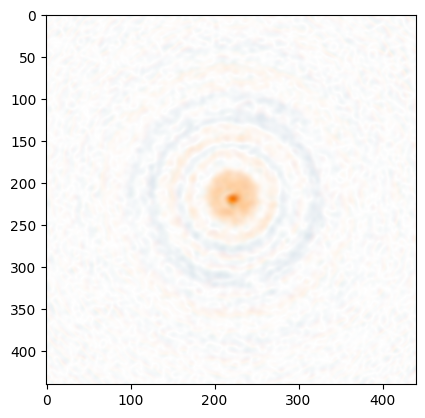

In [10]:
field = np.load("OneClumpFieldNPYs/shot1.npy")
complex2d_plot(field)

In [11]:
field.shape

(440, 440)

In [12]:
dx = 13e-6/(34.467e-6*11.000)
x_in = np.linspace(-220*dx,220.*dx,440)
x_out = np.linspace(-220*dx,220.*dx,440)
X_in,X_out = np.meshgrid(x_in,x_out)

y_in = np.linspace(-220*dx,220.*dx,440)
y_out = np.linspace(-220*dx,220.*dx,440)
Y_in,Y_out = np.meshgrid(y_in,y_out)

sources = np.zeros((440,440),dtype=np.complex128)
sources = np.array((X_in - 0.3)**2 + (Y_out)**2 < 0.3)

center = [0.0,0.0]
field2D = M_N_projection_2d(X_in-center[0],X_out-center[0],Y_in-center[1],Y_out-center[1],sources,0.02,0,4,7)

In [13]:
X_in[0,1] - X_in[0,0]

0.03436650275827535

In [14]:
ff_transform_x = mahler_kernel(X_in-center[0], X_out-center[0],-1j*np.pi*4/7)
ff_transform_y = mahler_kernel(Y_in-center[1], Y_out-center[1],-1j*np.pi*4/7)

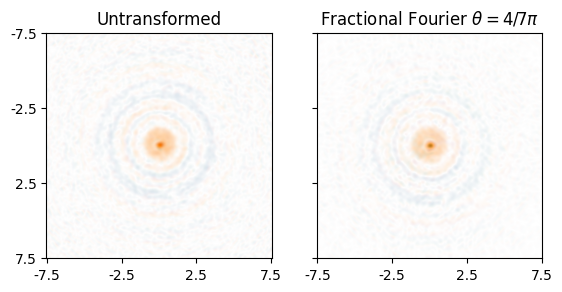

In [16]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True)
axs[0].set_title("Untransformed")
axs[0].set_yticks(np.arange(0,440,440//3), np.round(y_in[::440//3],1))
axs[0].set_xticks(np.arange(0,440,440//3), np.round(x_in[::440//3],1))
complex2d_plot(field, ax=axs[0])
axs[1].set_title("Fractional Fourier $\\theta=4/7\\pi$ ")
ff_field = ff_transform_x*dx @ field @ ff_transform_y*dx
complex2d_plot(ff_field, ax=axs[1])

In [17]:
print(np.linalg.norm(field))
np.linalg.norm(ff_field)

71.58402646452227


34.695539679002

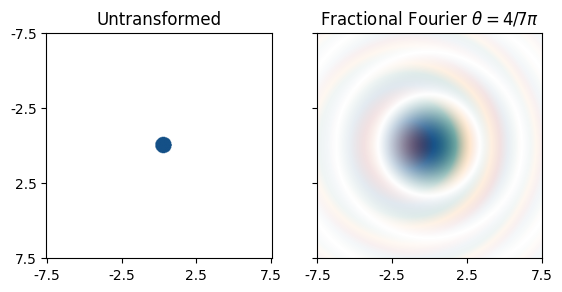

In [121]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True)
axs[0].set_title("Untransformed")
axs[0].set_yticks(np.arange(0,440,440//3), np.round(y_in[::440//3],1))
axs[0].set_xticks(np.arange(0,440,440//3), np.round(x_in[::440//3],1))
complex2d_plot(sources, ax=axs[0])
axs[1].set_title("Fractional Fourier $\\theta=4/7\\pi$ ")
complex2d_plot(ff_transform_x*dx @ sources @ ff_transform_y*dx, ax=axs[1])

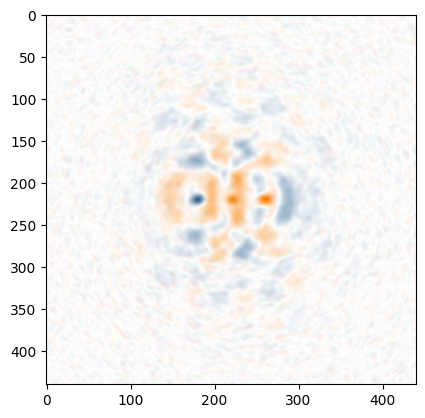

In [122]:
def ff_average(field, X_in, X_out, Y_in, Y_out, angle, reps, dx=None, dy=None, center=[0.,0.]):
    if dx is None:
        dx = X_in[0,1] - X_in[0,0]
    if dy is None:
        dy = Y_in[0,1] - Y_in[0,0]
    ff_transform_x = mahler_kernel(X_in-center[0], X_out-center[0],1j*angle)
    ff_transform_y = mahler_kernel(Y_in-center[1], Y_out-center[1],1j*angle)

    sum = field
    curr_field = field
    for i in range(reps):    
        curr_field = ff_transform_x*dx @ curr_field @ ff_transform_y*dy
        sum += curr_field
    return sum/(reps+1)
complex2d_plot(ff_average(field, X_in, X_out, Y_in, Y_out, -np.pi*4/7, 6))

(-0.5, 439.5, 439.5, -0.5)

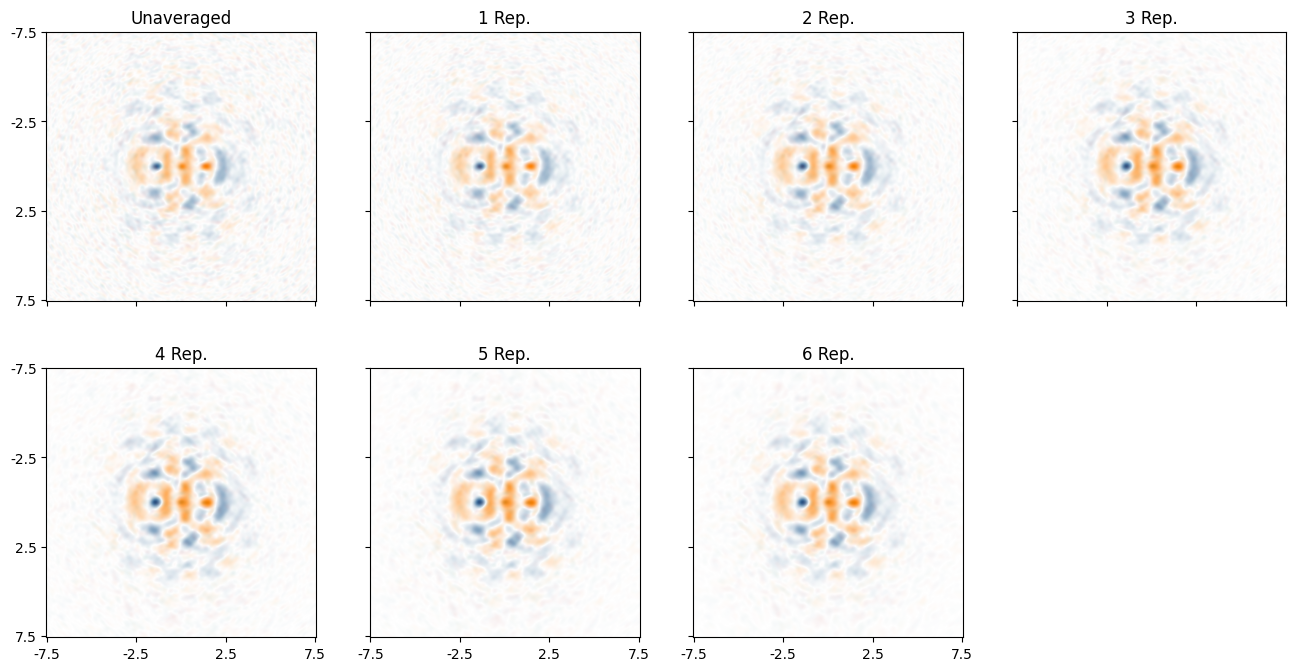

In [123]:
fig,axs = plt.subplots(2,4, sharex=True, sharey=True, figsize=(16,8))
# row 1
axs[0,0].set_title("Unaveraged")
axs[0,0].set_yticks(np.arange(0,440,440//3), np.round(y_in[::440//3],1))
axs[0,0].set_xticks(np.arange(0,440,440//3), np.round(x_in[::440//3],1))
complex2d_plot(ff_average(field, X_in, X_out, Y_in, Y_out, -np.pi*4/7, 0),ax=axs[0,0], gamma=1.)
axs[0,1].set_title("1 Rep.")
complex2d_plot(ff_average(field, X_in, X_out, Y_in, Y_out, -np.pi*4/7, 1),ax=axs[0,1], gamma=1.)
axs[0,2].set_title("2 Rep.")
complex2d_plot(ff_average(field, X_in, X_out, Y_in, Y_out, -np.pi*4/7, 2),ax=axs[0,2], gamma=1.)
axs[0,3].set_title("3 Rep.")
complex2d_plot(ff_average(field, X_in, X_out, Y_in, Y_out, -np.pi*4/7, 3),ax=axs[0,3], gamma=1.)

#row 2
axs[1,0].set_title("4 Rep.")
complex2d_plot(ff_average(field, X_in, X_out, Y_in, Y_out, -np.pi*4/7, 4),ax=axs[1,0], gamma=1.)
axs[1,1].set_title("5 Rep.")
complex2d_plot(ff_average(field, X_in, X_out, Y_in, Y_out, -np.pi*4/7, 5),ax=axs[1,1], gamma=1.)
axs[1,2].set_title("6 Rep.")
complex2d_plot(ff_average(field, X_in, X_out, Y_in, Y_out, -np.pi*4/7, 6),ax=axs[1,2], gamma=1.)
axs[1,3].axis('off')